**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_1_)    
      - [Importing Python Libraries](#toc1_1_1_1_)    
      - [Loading Clean Dataset](#toc1_1_1_2_)    
    - [Distribution of Reviews per product](#toc1_1_2_)    
    - [Word Counts in Reviews](#toc1_1_3_)    
    - [Review Sentiment Analysis](#toc1_1_4_)    
    - [Early Review Analysis](#toc1_1_5_)    
    - [Temporal nature of reviews](#toc1_1_6_)    
    - [Pickling the dataframe](#toc1_1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction](#toc0_)

In this notebook, we first merge the meta data with reviews dataframe and then perform pre-processing on first five reviews of products to make them suitable for modeling.

#### <a id='toc1_1_1_1_'></a>[Importing Python Libraries](#toc0_)

Importing necessary libraries for data pre-processing

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
import string
import spacy

# Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

In [64]:
#Useful settings

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set matplotlib global settings eg. figsize
sns.set_style("white")                   #Setting grid style in seaborn

#### <a id='toc1_1_1_2_'></a>[Loading Clean Dataset](#toc0_)

In [ ]:
# Here we load the pickled review DataFrame that has undergone basic cleaning   
review_df = pd.read_pickle('../data/review_sample_handmade.pkl')

#display first 5 rows
review_df.head()

,rating_by_user,title,text_review,images,product_id,parent_asin,user_id,time_of_review,helpful_vote,verified_purchase
0,5,Beautiful colors,I bought one for myself and one for my grandda...,[],B08GPJ1MSN,B08GPJ1MSN,AF7OANMNHQJC3PD4HRPX2FATECPA,2021-05-21 14:31:35.111,1,True
1,5,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,[],B084TWHS7W,B084TWHS7W,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,2020-04-24 21:15:46.965,0,True
2,5,Great,As pictured. Used a frame from the dollar stor...,[],B07V3NRQC4,B07V3NRQC4,AEYORY2AVPMCPDV57CE337YU5LXA,2020-06-06 13:09:11.297,0,True
3,5,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ...",[],B071ZMDK26,B071ZMDK26,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2019-06-02 01:14:39.784,2,True
4,5,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...,[],B01MPVZ4YP,B01MPVZ4YP,AGCPAPUHXYA3EEIL2KGSQTGO5HRA,2019-01-08 00:12:11.674,1,True


In [66]:
print(f'The shape of the review dataframe is {review_df.shape}.')

The shape of the review dataframe is (664162, 10).


In [67]:
#display info
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664162 entries, 0 to 664161
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating_by_user     664162 non-null  int64         
 1   title              664162 non-null  object        
 2   text_review        664162 non-null  object        
 3   images             664162 non-null  object        
 4   product_id         664162 non-null  object        
 5   parent_asin        664162 non-null  object        
 6   user_id            664162 non-null  object        
 7   time_of_review     664162 non-null  datetime64[ns]
 8   helpful_vote       664162 non-null  int64         
 9   verified_purchase  664162 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 46.2+ MB


In [68]:
#checking null values 
review_df.isna().sum().loc[lambda x: x> 0]

Series([], dtype: int64)

In [69]:
# Number of products 
print("Number of products reviewed:", review_df['parent_asin'].nunique())

# Number of unique reviewers 
print("Number of unique reviewers:", review_df['user_id'].nunique())

# Range of ratings
print("Ratings range from:", review_df['rating_by_user'].min(), "to", review_df['rating_by_user'].max())

Number of products reviewed: 164728
Number of unique reviewers: 586613
Ratings range from: 1 to 5


### <a id='toc1_1_2_'></a>[Distribution of Reviews per product](#toc0_)

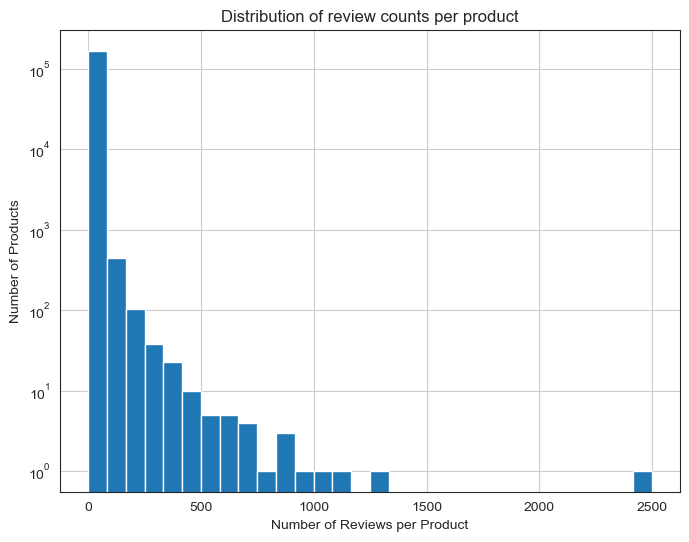

In [70]:
grouped_df = review_df.groupby('parent_asin',as_index=False)['rating_by_user'].count().rename(columns= {'rating_by_user':'review_counts'})
grouped_df['review_counts'].hist(bins=30)

#title and axis labels
plt.xlabel('Number of Reviews per Product')
plt.ylabel('Number of Products')
plt.title('Distribution of review counts per product')
plt.yscale('log')
plt.show()

In [71]:
grouped_df['review_counts'].describe()

count    164728.000000
mean          4.031871
std          16.397329
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2498.000000
Name: review_counts, dtype: float64

**Key Insights**

- The distribution reveals a highly skewed distribution of reviews per product, with most products receiving very few ratings. 
- About 50% of products have only received a single review and about 75% of products have ≤3 reviews. 
- The presence of long tail shows that select items attract disproportionate attention from users.


### <a id='toc1_1_3_'></a>[Word Counts in Reviews](#toc0_)

In [72]:
# Function to clean text: remove punctuation & emojis, then split
def clean_and_split(text):
        # Remove HTML tags like <br />
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
        text = re.sub(r"[\U00010000-\U0010FFFF]", " ", text, flags=re.UNICODE)  # Remove emojis
        return text

#apply to review titles
review_df['review_title_cleaned'] = review_df['title'].apply(clean_and_split)

review_df['review_title_cleaned'].head()

0                              Beautiful colors
1    You simply must order order more than one 
2                                         Great
3                    Well made and so beautiful
4              Smells just like the real thing 
Name: review_title_cleaned, dtype: object

In [73]:
#clean review text

review_df['review_text_cleaned'] = review_df['text_review'].apply(clean_and_split)

review_df['review_text_cleaned'].head()

0    I bought one for myself and one for my grandda...
1    I ve ordered three bows so far  Have not been ...
2    As pictured  Used a frame from the dollar stor...
3    This is beyond beautiful   So shiny  the size ...
4    Oh wow what a pleasant surprise  This smells g...
Name: review_text_cleaned, dtype: object

In [74]:
#calculate the word counts in text and title of reviews

# Apply to the cleaned review text column
review_df['review_text_word_counts'] = review_df['review_text_cleaned'].str.split().apply(len)

# Apply to the cleaned title colbumn
review_df['review_title_word_counts'] = review_df['review_title_cleaned'].str.split().apply(len)

review_df[['review_text_word_counts','review_title_word_counts']].describe()

,review_text_word_counts,review_title_word_counts
count,664162.000000,664162.000000
mean,25.504717,3.452743
std,29.935683,2.767256
min,0.000000,0.000000
25%,8.000000,2.000000
50%,17.000000,2.000000
75%,33.000000,4.000000
max,1782.000000,46.000000


### <a id='toc1_1_4_'></a>[Review Sentiment Analysis](#toc0_)

In this section, we use Vader Sentiment scores to calculate sentiment scores based on the combined title and text of the reviews. Since VADER is optimized for social media, product reviews, and informal text, it is good choice for this analysis.

In [75]:
#First Create a column that combines text and title of the review
review_df['review'] = review_df['title'] + ' ' + review_df['text_review']
review_df['review'].head()

0    Beautiful colors I bought one for myself and o...
1    You simply must order order more than one! I’v...
2    Great As pictured. Used a frame from the dolla...
3    Well made and so beautiful This is beyond beau...
4    Smells just like the real thing! Oh wow what a...
Name: review, dtype: object

In [76]:
#calculate sentiment of these early reviews
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get Vader Scores
def get_vader_scores(text):
    return analyzer.polarity_scores(str(text))

# Apply to both title and text
review_df['review_sentiment'] = review_df['review'].apply(lambda x: get_vader_scores(x)['compound'])


Correlation Matrix:
                  review_sentiment  rating_by_user
review_sentiment          1.000000        0.700317
rating_by_user            0.700317        1.000000


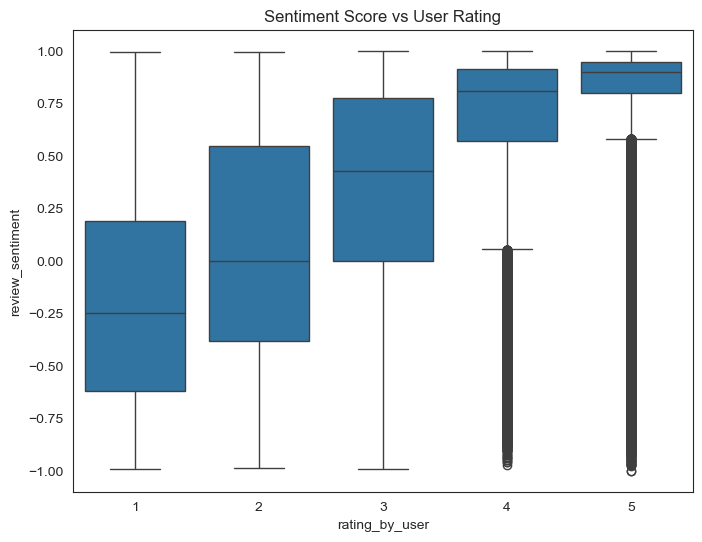

In [77]:
#compare vader scores with actual user ratings

# Correlation check
print('Correlation Matrix:')
print(review_df[['review_sentiment', 'rating_by_user']].corr())

# Visual comparison
sns.boxplot(x='rating_by_user', y='review_sentiment', data=review_df)
plt.title('Sentiment Score vs User Rating')
plt.show()

**Key Insights**

- Vader scores generally align with user ratings, showing higher average sentiment scores for 4- and 5-star reviews.

- The distribution of Vader scores is tighter for 4 and 5-star ratings compared to lower ratings, indicating that the model is more consistent in capturing positive sentiment than negative sentiment.

- While the median Vader score for 4 and 5-star reviews are high, there are numerous outliers with significantly lower sentiment scores. This suggests that Vader struggles to capture positive sentiment in some highly-rated reviews, potentially due to neutral or mixed language.

### <a id='toc1_1_5_'></a>[Early Review Analysis](#toc0_)

In this section, we analyze specific features of early reviews of products and create a dataframe to store these early reviews for later use as features in our model. We will also establish a baseline sentiment score using VADER for these early reviews.

In [78]:
review_df.groupby('parent_asin',
                )['rating_by_user'].count().loc[lambda x: x > 20]

parent_asin
B001RMKWM6    22
B0155Y8RQY    21
B0157CCJ7C    32
B0158SFDUA    29
B01591IOQG    81
              ..
B0CC8ZC5GW    70
B0CCVB4W21    33
B0CDLTRQGM    29
B0CDP4724X    32
B0CG562C9R    37
Name: rating_by_user, Length: 4630, dtype: int64

In [79]:
#First find products with atleast 20 reviews
valid_ids = review_df.groupby('parent_asin') \
            ['rating_by_user'].count().loc[lambda x: x > 20].index

#filter those products
products_min_20_reviews = review_df[review_df['parent_asin'].isin(valid_ids)].copy()


In [80]:
# Sort reviews by time (oldest first) and group by product to calculate early verified ratio
early_verified = (
    products_min_20_reviews.sort_values('time_of_review')
    .groupby('parent_asin')
    .head(5)
    .groupby('parent_asin')['verified_purchase']
    .mean()
    .rename('early_verified_ratio')
)


In [81]:
#calculate early_rating_average
early_ratings = (
    products_min_20_reviews.sort_values('time_of_review')
    .groupby('parent_asin')
    .head(5)
    .groupby('parent_asin')['rating_by_user']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'early_rating_avg', 'count': 'early_review_count'})
)

In [82]:
#calculate early_sentiment_score
early_sentiment = (
    products_min_20_reviews.sort_values('time_of_review')
    .groupby('parent_asin')
    .head(5)
    .groupby('parent_asin')['review_sentiment']
    .mean()
    .rename('early_sentiment')
)

In [83]:
#calculate word counts in review title/text
early_wordcounts = (
    products_min_20_reviews.sort_values('time_of_review')
    .groupby('parent_asin')
    .head(5)
    .groupby('parent_asin')[['review_title_word_counts', 'review_text_word_counts']]
    .mean()
    .rename(columns={'review_title_word_counts': 'early_review_title_word_counts', 'review_text_word_counts': 'early_review_text_word_counts'})
)

In [84]:
# Combine all features into a dataframe 
early_features = pd.concat([early_ratings, early_verified, early_sentiment,early_wordcounts], axis=1)

early_features = early_features.reset_index()
early_features.head()

,parent_asin,early_rating_avg,early_review_count,early_verified_ratio,early_sentiment,early_review_title_word_counts,early_review_text_word_counts
0,B001RMKWM6,3.6,5,0.6,0.26130,2.8,56.8
1,B0155Y8RQY,5.0,5,1.0,0.71510,2.6,14.8
2,B0157CCJ7C,4.8,5,1.0,0.81328,3.8,15.6
3,B0158SFDUA,5.0,5,1.0,0.90284,2.4,22.8
4,B01591IOQG,5.0,5,0.8,0.88314,3.6,39.6


In [85]:
#sanity check that there are only 5 reviews per product
early_features['early_review_count'].value_counts()

early_review_count
5    4630
Name: count, dtype: int64

In [86]:
#we can now delete this column
early_features.drop(columns='early_review_count',inplace=True)

### <a id='toc1_1_6_'></a>[Temporal nature of reviews](#toc0_)

This section analyzes products with sufficient review history to quantify how early ratings (first 5 reviews) predict long-term popularity. We’ll also identify products where early signals diverged from final outcomes

In [87]:
# Filter products with robust review history so that we can calculate a meaningful long term rating
MIN_REVIEWS = 30   # Minimum number of reviews
MIN_DAYS = 90      # At least 3 months of data

eligible_products = review_df.groupby('parent_asin').filter(
    lambda x: (len(x) >= MIN_REVIEWS) & 
              ((x['time_of_review'].max() - x['time_of_review'].min()).days >= MIN_DAYS)
)

print(f"Eligible products: {eligible_products['parent_asin'].nunique()} out of Total Products: {review_df['parent_asin'].nunique()}")

Eligible products: 2816 out of Total Products: 164728


In [88]:
eligible_products['long_term_rating'] = eligible_products.groupby('parent_asin',as_index=False)['rating_by_user'].transform('median')

eligible_products = eligible_products.merge(early_features[['parent_asin','early_rating_avg']], on ='parent_asin',how='left')

In [89]:
#calculate delta between long term and early ratings
eligible_products['delta_ratings'] = eligible_products['long_term_rating'] - eligible_products['early_rating_avg']
eligible_products['delta_ratings'].describe()


count    216067.000000
mean          0.270268
std           0.514390
min          -3.200000
25%           0.000000
50%           0.000000
75%           0.400000
max           3.000000
Name: delta_ratings, dtype: float64

While most products show no difference between the early rating average and the long-term rating, there are a few outliers. We see a few examples of these outliers below.

In [90]:
#Filter products with large deltas
interesting = eligible_products[
    (abs(eligible_products['delta_ratings']) >= 1.0)  # Large rating shifts
].sort_values('delta_ratings', key=abs, ascending=False).reset_index(drop=True)

interesting.head()

,rating_by_user,title,text_review,images,product_id,parent_asin,user_id,time_of_review,helpful_vote,verified_purchase,review_title_cleaned,review_text_cleaned,review_text_word_counts,review_title_word_counts,review,review_sentiment,long_term_rating,early_rating_avg,delta_ratings
0,1,Garbage,"Cheaply made, impossibly small, with no gift b...",[{'small_image_url': 'https://m.media-amazon.c...,B08CTCMGYL,B08ZYQHW7Y,AF3R4PFRYJWNA323LFMFN7CZWCVQ,2022-11-18 19:40:42.532,0,True,Garbage,Cheaply made impossibly small with no gift b...,22,1,"Garbage Cheaply made, impossibly small, with n...",-0.7494,1.0,4.2,-3.2
1,1,Do not lay flat to the ear as shown in picture,Do not lay flat to the ear as picture show it ...,[],B08BNR4RMY,B08ZYQHW7Y,AEJFSONVKQ4CLAFNKULGJBSHZZWA,2022-01-01 15:45:43.239,0,True,Do not lay flat to the ear as shown in picture,Do not lay flat to the ear as picture show it ...,12,11,Do not lay flat to the ear as shown in picture...,0.0000,1.0,4.2,-3.2
2,2,Do not stay in place,They look like hammered partial paper clips bu...,[],B08BNR4RMY,B08ZYQHW7Y,AHN7R73BN5RPOABGO3TGQGLMUEEA,2023-01-05 22:45:29.511,1,True,Do not stay in place,They look like hammered partial paper clips bu...,41,5,Do not stay in place They look like hammered p...,-0.2960,1.0,4.2,-3.2
3,4,"Pretty, but small","They are very pretty, but smaller than I expec...",[],B08CVLW7BK,B08ZYQHW7Y,AH55Z7EM4T5LC2P7UCZX4P2WXTRQ,2021-04-20 03:10:53.141,2,True,Pretty but small,They are very pretty but smaller than I expec...,56,3,"Pretty, but small They are very pretty, but sm...",0.9030,1.0,4.2,-3.2
4,1,Cheap,These are cheap. I do not recommend. One of th...,[{'small_image_url': 'https://m.media-amazon.c...,B08CTCRQYL,B08ZYQHW7Y,AEUV3MLBQCGZS2L4D7VD62VZPNRA,2022-08-22 20:14:20.916,0,True,Cheap,These are cheap I do not recommend One of th...,31,1,Cheap These are cheap. I do not recommend. One...,-0.7576,1.0,4.2,-3.2


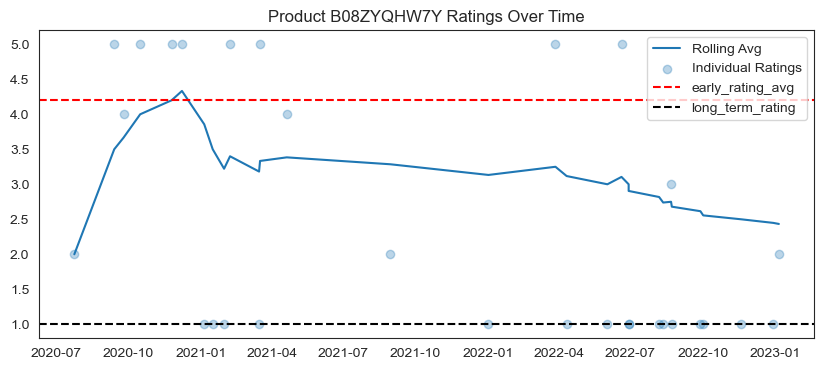

In [107]:
#Pick the product with the worst delta
item1 = interesting.loc[0, 'parent_asin']

#sort reviews by time
product_reviews = review_df[review_df['parent_asin'] == item1].sort_values('time_of_review')

plt.figure(figsize=(10, 4))

plt.plot(product_reviews['time_of_review'], product_reviews['rating_by_user'].expanding().mean(), label='Rolling Avg')
plt.scatter(product_reviews['time_of_review'], product_reviews['rating_by_user'], alpha=0.3, label='Individual Ratings')

plt.axhline(early_features.loc[early_features['parent_asin']== item1,'early_rating_avg'].values,ls='--',color='red',label='early_rating_avg')
plt.axhline(interesting.loc[interesting['parent_asin']== item1,'long_term_rating'].max(),ls='--',color='black',label='long_term_rating')

plt.title(f"Product {item1} Ratings Over Time")
plt.legend()
plt.show()


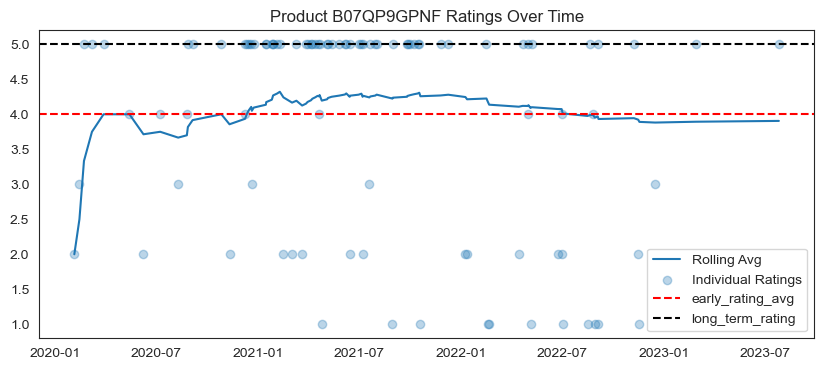

In [106]:
#take an example of a product with delta close to 1

item2 = interesting.loc[len(interesting)-1, 'parent_asin']

#sort reviews by time
product_reviews = review_df[review_df['parent_asin'] == item2].sort_values('time_of_review')

plt.figure(figsize=(10, 4))

plt.plot(product_reviews['time_of_review'], product_reviews['rating_by_user'].expanding().mean(), label='Rolling Avg')
plt.scatter(product_reviews['time_of_review'], product_reviews['rating_by_user'], alpha=0.3, label='Individual Ratings')

plt.axhline(early_features.loc[early_features['parent_asin']== item2,'early_rating_avg'].values,ls='--',color='red',label='early_rating_avg')
plt.axhline(interesting.loc[interesting['parent_asin']== item2,'long_term_rating'].max(),ls='--',color='black',label='long_term_rating')

plt.title(f"Product {item2} Ratings Over Time")
plt.legend()
plt.show()

About 50% of the products show no deviation between their early ratings and long term ratings, suggesting that early ratings could be a useful predictor of long-term product popularity.

### <a id='toc1_1_7_'></a>[Pickling the dataframe](#toc0_)

In [71]:
#display the columns in the final dataframe
early_features.columns

Index(['parent_asin', 'early_rating_avg', 'early_verified_ratio',
       'early_sentiment', 'early_review_title_word_counts',
       'early_review_text_word_counts'],
      dtype='object')

In [108]:
#sanity check missing values 
early_features.isna().sum().loc[lambda x: x>0]

Series([], dtype: int64)

In [72]:
early_features.to_pickle('../data/early_reviews.pkl')

### Conclusion

In this notebook, we created a dataframe containing the average ratings, verified purchase ratio, sentiment, and word counts in review texts for products with sufficient review history. Next, we will examine how incorporating these review-based features alongside product metadata impacts popularity prediction.